In [ ]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning

from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from keras import regularizers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from keras.optimizers import adam_v2
import tensorflow as tf
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import random


In [ ]:
!git clone https://github.com/sahilabudhwani/ML-Detection-for-Malaria.git

fatal: destination path 'ML-Detection-for-Malaria' already exists and is not an empty directory.


In [ ]:
import fnmatch 
data=[]
labels=[]

Parasitized=fnmatch.filter(os.listdir("/content/ML-Detection-for-Malaria/Malaria_Dataset/Parasitized"), '*png')
for a in Parasitized: 
    img= Image.open(r'/content/ML-Detection-for-Malaria/Malaria_Dataset/Parasitized/' +a)
    img=img.resize((128,128)) 
    data.append(np.asarray(img))
    labels.append(0)
  


Uninfected=fnmatch.filter(os.listdir("/content/ML-Detection-for-Malaria/Malaria_Dataset/Uninfected"), '*png')
for u in Uninfected: 
    img= Image.open(r'/content/ML-Detection-for-Malaria/Malaria_Dataset/Uninfected/' +u)
    img=img.resize((128,128)) 
    data.append(np.asarray(img))
    labels.append(1)
    

In [ ]:
Cells=np.array(data)
labels=np.array(labels)
print(Cells.shape, labels.shape)

(27558, 128, 128, 3) (27558,)


In [ ]:
Cells=np.stack(data)
labels=np.stack(labels)
print(Cells.shape, labels.shape)

(27558, 128, 128, 3) (27558,)


In [ ]:
np.save("Cells",Cells)
np.save("labels",labels)

In [ ]:
Cells=np.load("Cells.npy",allow_pickle=True)
labels=np.load("labels.npy",allow_pickle=True)

In [ ]:
num_classes = 2

labels = keras.utils.np_utils.to_categorical(labels, num_classes)
print(labels[0])

[1. 0.]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(Cells, labels, test_size = 0.2, random_state=5)
print('Train dataset number: {}'.format(len(x_train)))
print('Test dataset number: {}'.format(len(x_val)))

Train dataset number: 22046
Test dataset number: 5512


In [ ]:
#creating sequential model
model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2),activation='relu',input_shape=(128,128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 63, 63, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)      

In [ ]:
model.compile(tf.optimizers.Adam(lr=0.001) , loss = "categorical_crossentropy", metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
batch_size = 30
epochs = 25

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model3.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks_list,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/25
735/735 [==============================] - ETA: 0s - loss: 0.7110 - accuracy: 0.5914
Epoch 1: val_loss improved from inf to 0.31154, saving model to model3.h5
735/735 [==============================] - 486s 659ms/step - loss: 0.7110 - accuracy: 0.5914 - val_loss: 0.3115 - val_accuracy: 0.9084
Epoch 2/25
735/735 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9277
Epoch 2: val_loss improved from 0.31154 to 0.18313, saving model to model3.h5
735/735 [==============================] - 488s 663ms/step - loss: 0.2588 - accuracy: 0.9277 - val_loss: 0.1831 - val_accuracy: 0.9458
Epoch 3/25
735/735 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9463
Epoch 3: val_loss did not improve from 0.18313
735/735 [==============================] - 486s 661ms/step - loss: 0.1792 - accuracy: 0.9463 - val_loss: 0.1891 - val_accuracy: 0.9478
Epoch 4/25
735/735 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9520
Epoch 4: val

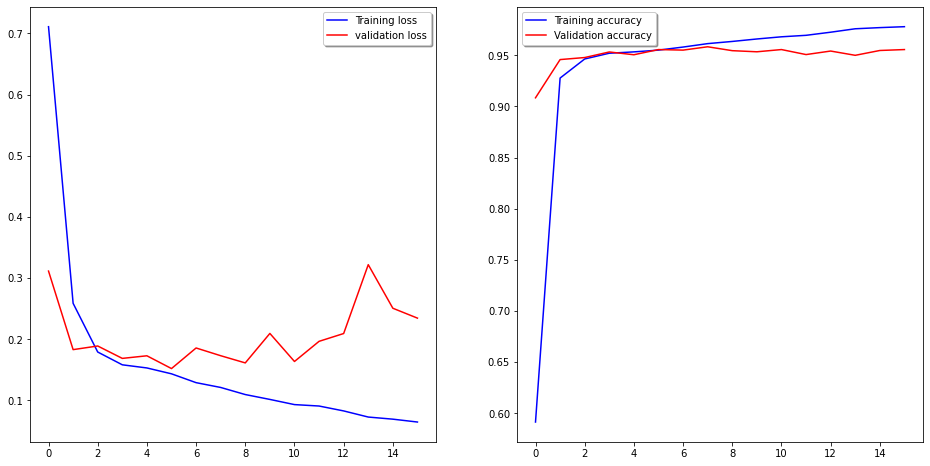

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model3.h5')

In [ ]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15217295289039612
Test accuracy: 0.9555515050888062


In [ ]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

  Uninfected       0.97      0.94      0.96      2785
   Parasited       0.94      0.97      0.96      2727

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



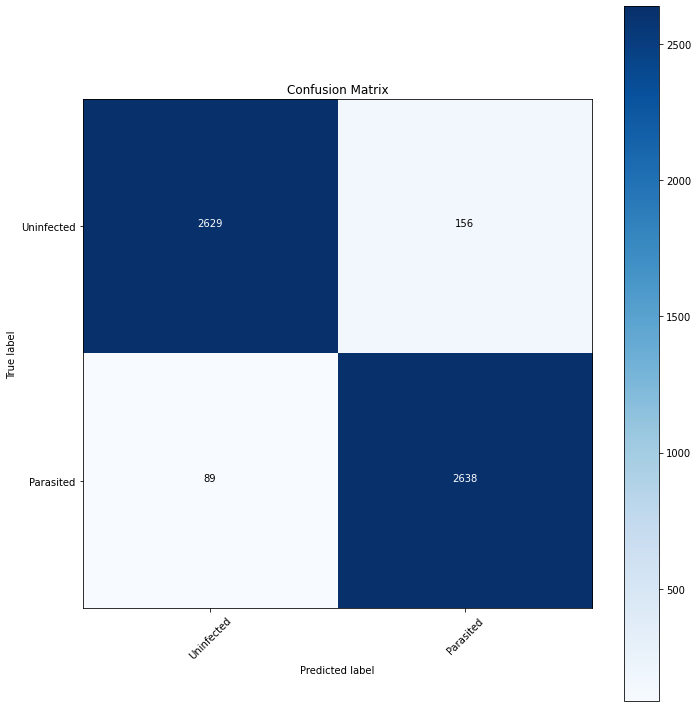

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(x_val) > 0.5).astype("int32")

y_test_c = np.argmax(y_val, axis=1)
target_names = ["Uninfected", "Parasited"]

Y_pred = np.argmax(model.predict(x_val),axis=1)
print('Confusion Matrix')
cm =confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))